In [1]:
!pip install pickle5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 256 kB 34.0 MB/s 


In [2]:
from sklearn.utils import shuffle
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense, Concatenate, Flatten
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications import ResNet50
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import pickle5 as pickle
seed = 2022
np.random.seed(seed)
tf.random.set_seed(seed)

In [3]:
# connect google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# mfcc data
with open("/content/drive/MyDrive/멀캠_2nd_semiproject/데이터/mfcc/mfcc_1565_data.pickle","rb") as fr:
    data = pickle.load(fr)

length=[]
for i in range(len(data)):
    length.append(data[i].shape[1])
    
min_len=min(length)

result=[]
for i in range(len(data)):
    result.append(data[i][:,:min_len])
    
result_data = np.array(result)
X = result_data

In [13]:
# 그 외 데이터 - man, respiratory_condition, fever_muscle_pain
df_info = pd.read_csv('/content/drive/MyDrive/멀캠_2nd_semiproject/데이터/man-fever_1565.csv')
df_info = df_info[['man', 'respiratory_condition', 'fever_muscle_pain']]

In [14]:
# y data
y_df = pd.read_csv('/content/drive/MyDrive/멀캠_2nd_semiproject/데이터/mfcc/Y_data_1516.csv')
y_df.head()

,COVID-19,healthy
0,0,1
1,0,1
2,0,1
3,0,1
4,0,1


In [15]:
df_info.head()

,man,respiratory_condition,fever_muscle_pain
0,1,1,0
1,1,1,0
2,1,1,0
3,1,1,0
4,1,0,0


In [16]:
df_info.shape, y_df.shape

((2304, 3), (2304, 2))

In [17]:
df_con = pd.concat([df_info, y_df], axis=1)

In [18]:
df_con.shape

(2304, 5)

In [19]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X, df_con, stratify = df_con, test_size = 0.2
)

In [48]:
features_train = Y_train.iloc[:,:-2].values
y_data_train = Y_train.iloc[:,-2].values #COVID-19

features_test = Y_test.iloc[:,:-2].values
y_data_test = Y_test.iloc[:,-2].values #COVID-19

In [46]:
Y_train

,man,respiratory_condition,fever_muscle_pain,COVID-19,healthy
281,1,0,0,0,1
1295,0,0,0,0,1
2033,0,1,1,1,0
853,1,0,0,1,0
643,1,1,0,1,0
...,...,...,...,...,...
1294,0,0,0,0,1
1743,0,1,1,1,0
1239,0,0,0,0,1
1840,0,1,1,1,0


In [47]:
y_data_train.shape

(1843,)

In [45]:
features_train

array([[1, 0, 0],
       [0, 0, 0],
       [0, 1, 1],
       ...,
       [0, 0, 0],
       [0, 1, 1],
       [0, 0, 0]])

In [21]:
from keras import models, layers
from keras import Input
from keras.models import Model, load_model
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers, initializers, regularizers, metrics
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import BatchNormalization, Conv2D, Activation, Dense, GlobalAveragePooling2D, MaxPooling2D, ZeroPadding2D, Add
 
import os
import matplotlib.pyplot as plt
import numpy as np
import math

In [22]:
# https://eremo2002.tistory.com/76
def conv1_layer(x):    
    x = ZeroPadding2D(padding=(3, 3))(x)
    x = Conv2D(64, (7, 7), strides=(2, 2))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = ZeroPadding2D(padding=(1,1))(x)
 
    return x   
 
    
 
def conv2_layer(x):         
    x = MaxPooling2D((3, 3), 2)(x)     
 
    shortcut = x
 
    for i in range(3):
        if (i == 0):
            x = Conv2D(64, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            x = Conv2D(256, (1, 1), strides=(1, 1), padding='valid')(x)
            shortcut = Conv2D(256, (1, 1), strides=(1, 1), padding='valid')(shortcut)            
            x = BatchNormalization()(x)
            shortcut = BatchNormalization()(shortcut)
 
            x = Add()([x, shortcut])
            x = Activation('relu')(x)
            
            shortcut = x
 
        else:
            x = Conv2D(64, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            x = Conv2D(256, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)            
 
            x = Add()([x, shortcut])   
            x = Activation('relu')(x)  
 
            shortcut = x        
    
    return x
 
 
 
def conv3_layer(x):        
    shortcut = x    
    
    for i in range(4):     
        if(i == 0):            
            x = Conv2D(128, (1, 1), strides=(2, 2), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)        
            
            x = Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)  
 
            x = Conv2D(512, (1, 1), strides=(1, 1), padding='valid')(x)
            shortcut = Conv2D(512, (1, 1), strides=(2, 2), padding='valid')(shortcut)
            x = BatchNormalization()(x)
            shortcut = BatchNormalization()(shortcut)            
 
            x = Add()([x, shortcut])    
            x = Activation('relu')(x)    
 
            shortcut = x              
        
        else:
            x = Conv2D(128, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            x = Conv2D(512, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)            
 
            x = Add()([x, shortcut])     
            x = Activation('relu')(x)
 
            shortcut = x      
            
    return x
 
 
 
def conv4_layer(x):
    shortcut = x        
  
    for i in range(6):     
        if(i == 0):            
            x = Conv2D(256, (1, 1), strides=(2, 2), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)        
            
            x = Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)  
 
            x = Conv2D(1024, (1, 1), strides=(1, 1), padding='valid')(x)
            shortcut = Conv2D(1024, (1, 1), strides=(2, 2), padding='valid')(shortcut)
            x = BatchNormalization()(x)
            shortcut = BatchNormalization()(shortcut)
 
            x = Add()([x, shortcut]) 
            x = Activation('relu')(x)
 
            shortcut = x               
        
        else:
            x = Conv2D(256, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            x = Conv2D(1024, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)            
 
            x = Add()([x, shortcut])    
            x = Activation('relu')(x)
 
            shortcut = x      
 
    return x
 
 
 
def conv5_layer(x):
    shortcut = x    
  
    for i in range(3):     
        if(i == 0):            
            x = Conv2D(512, (1, 1), strides=(2, 2), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)        
            
            x = Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)  
 
            x = Conv2D(2048, (1, 1), strides=(1, 1), padding='valid')(x)
            shortcut = Conv2D(2048, (1, 1), strides=(2, 2), padding='valid')(shortcut)
            x = BatchNormalization()(x)
            shortcut = BatchNormalization()(shortcut)            
 
            x = Add()([x, shortcut])  
            x = Activation('relu')(x)      
 
            shortcut = x               
        
        else:
            x = Conv2D(512, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            x = Conv2D(2048, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)           
            
            x = Add()([x, shortcut]) 
            x = Activation('relu')(x)       
 
            shortcut = x                  
 
    return x


In [23]:
mfcc_input = Input(shape = (30,901,1), name = "features_train")
info_input = Input(shape = (3,), name = "other info")

In [24]:
#mfcc_input = Input(shape = X.shape[1:], name = "features_train")

In [50]:
#x = conv1_layer(mfcc_input)
#x = conv2_layer(x)
x_1 = conv2_layer(mfcc_input)
x_1 = conv3_layer(x_1)
x_1 = conv4_layer(x_1)
x_1 = conv5_layer(x_1)
 
x_1 = GlobalAveragePooling2D()(x_1)

# 피쳐 입력
x_2 = Dense(128, input_dim = 3 ,activation  = "relu")(info_input)
x_2 = Dense(32, activation = "relu")(info_input)

# 출력을 만들기 위해 모든 입력을 하나의 텐서로 합침
x = Concatenate()([x_1, x_2])

#output_tensor = Dense(, activation='sigmoid')(x)
output_tensor = Dense(1, activation='sigmoid')(x)

In [51]:
 
resnet50 = Model([mfcc_input, info_input], output_tensor)
resnet50.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 features_train (InputLayer)    [(None, 30, 901, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 max_pooling2d_4 (MaxPooling2D)  (None, 14, 450, 1)  0           ['features_train[0][0]']         
                                                                                                  
 conv2d_208 (Conv2D)            (None, 14, 450, 64)  128         ['max_pooling2d_4[0][0]']        
                                                                                                  
 batch_normalization_208 (Batch  (None, 14, 450, 64)  256        ['conv2d_208[0][0]']       

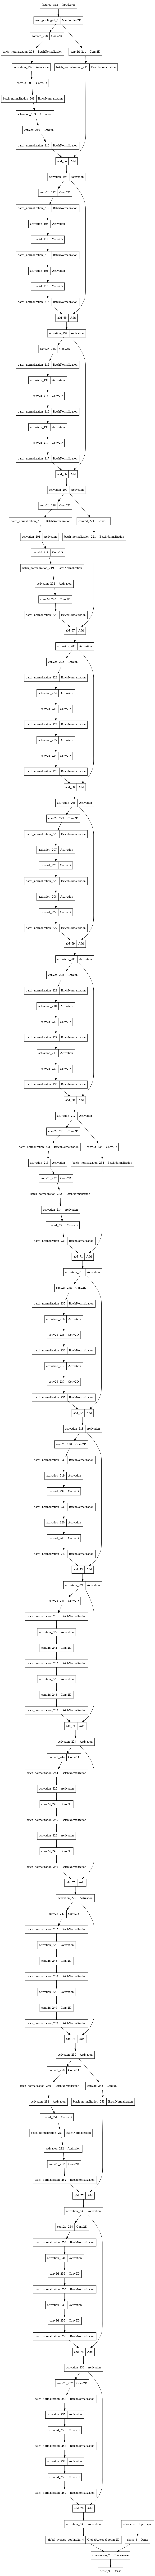

In [52]:
from tensorflow.keras.utils import plot_model
plot_model(resnet50)

In [53]:
features_train

array([[1, 0, 0],
       [0, 0, 0],
       [0, 1, 1],
       ...,
       [0, 0, 0],
       [0, 1, 1],
       [0, 0, 0]])

In [54]:
resnet50.compile(optimizer = "adam",
              loss = "binary_crossentropy", metrics = ["accuracy"])

In [55]:
model_path = "functional-resnet-mfcc.h5"
mc = ModelCheckpoint(model_path, save_best_only=True, verbose=1, monitor = "val_accuracy")
es = EarlyStopping(patience=10, monitor = "val_accuracy")

In [42]:
y_data_train

array([0, 0, 1, ..., 0, 1, 0])

In [56]:
hist = resnet50.fit([X_train, features_train] , y_data_train,
                 epochs = 50, batch_size = 50,
                 validation_split=0.2, callbacks = [es, mc])

Epoch 1/50
30/30 [==============================] - ETA: 0s - loss: 1.0119 - accuracy: 0.5210
Epoch 1: val_accuracy improved from -inf to 0.51491, saving model to functional-resnet-mfcc.h5
30/30 [==============================] - 54s 1s/step - loss: 1.0119 - accuracy: 0.5210 - val_loss: 77.2582 - val_accuracy: 0.5149
Epoch 2/50
30/30 [==============================] - ETA: 0s - loss: 0.6909 - accuracy: 0.5719
Epoch 2: val_accuracy did not improve from 0.51491
30/30 [==============================] - 30s 987ms/step - loss: 0.6909 - accuracy: 0.5719 - val_loss: 1.7050 - val_accuracy: 0.5041
Epoch 3/50
30/30 [==============================] - ETA: 0s - loss: 0.6900 - accuracy: 0.5760
Epoch 3: val_accuracy improved from 0.51491 to 0.52846, saving model to functional-resnet-mfcc.h5
30/30 [==============================] - 31s 1s/step - loss: 0.6900 - accuracy: 0.5760 - val_loss: 1.3185 - val_accuracy: 0.5285
Epoch 4/50
30/30 [==============================] - ETA: 0s - loss: 0.6727 - accura

In [57]:
best_model = load_model(model_path)
best_model.evaluate([X_test, features_test] , y_data_test)

15/15 [==============================] - 5s 208ms/step - loss: 0.6349 - accuracy: 0.6399


[0.6348599195480347, 0.6399132609367371]

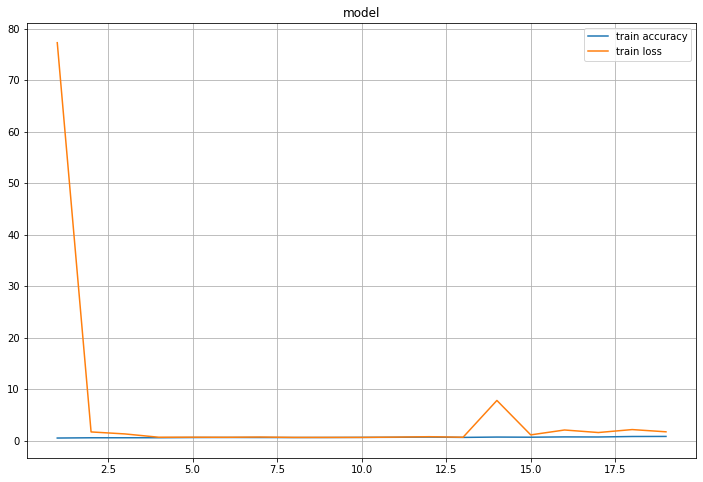

In [60]:
y_acc = hist.history['accuracy']
y_vloss = hist.history['val_loss']
xs =np.arange(1, len(y_acc)+1) # 시작을 1번부터 해주기 위해서

plt.figure(figsize=(12,8))
plt.plot(xs, y_acc, label='train accuracy')
plt.plot(xs, y_vloss, label='train loss')
plt.legend(), plt.grid()
plt.title('model')
plt.show()

In [ ]:
best_model = load_model(model_path)
best_model.evaluate(X_test, y_test)

15/15 [==============================] - 5s 220ms/step - loss: 0.7176 - accuracy: 0.6291


[0.7176066637039185, 0.6290672421455383]